# MNIST and NN model insterpretation?

In this exercise we will work with a full size version of the MNIST dataset of handwritten digits.

## Model Training

In [62]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)


* 1️⃣ Check out the shape of the objects you find in the dataset

In [63]:
image, target = next(iter(mnist_dataset))

In [64]:
image.shape

torch.Size([1, 28, 28])

* 2️⃣ Visualize one element from this dataset
<Note type="tip" title=".squeeze">
You may have to use a method called `.squeeze()`, checkout what it does.
</Note>

In [65]:
from plotly import express as px
px.imshow(image.squeeze(), color_continuous_scale="gray")

* 3️⃣ This data shape won't fit in a fully connected neural network, reshape the elements from the dataset so they are flat.

In [66]:
# Split dataset into training and validation
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

* 4️⃣ 
    * What is the effect of the batch size on the training of the model? If the batch size is equal to the number of observations, what would the batch gradient descent be equivalent to?
    * With batches of 16 observations, how many times will the parameters of the model be updated before we reach one epoch?

* 5️⃣ Create a simple neural network model, don't forget to set an input shape in the first layer that corresponds to the data we will feed the model and define the last layer so it is able to make predictions as we expect.

In [67]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

model = MNISTModel()
print(model)

MNISTModel(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


* 6️⃣ Define the Loss Function and Optimizer

In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

* 7️⃣ Train the model on 50 epochs

In [69]:
import torch

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    """
    Function to train a PyTorch model with training and validation datasets.
    
    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).
    
    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """
    
    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate batch loss
            correct += (torch.argmax(outputs,dim=1) == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (torch.argmax(outputs,dim=1) == labels).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)
        
        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return history  # Return training history

# Train the model
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=50)


Epoch [1/50], Loss: 1.8364, Acc: 0.6359, Val Loss: 1.7432, Val Acc: 0.7220
Epoch [2/50], Loss: 1.6926, Acc: 0.7743, Val Loss: 1.6618, Val Acc: 0.8046
Epoch [3/50], Loss: 1.6522, Acc: 0.8119, Val Loss: 1.6445, Val Acc: 0.8181
Epoch [4/50], Loss: 1.6434, Acc: 0.8198, Val Loss: 1.6384, Val Acc: 0.8233
Epoch [5/50], Loss: 1.6405, Acc: 0.8220, Val Loss: 1.6373, Val Acc: 0.8244
Epoch [6/50], Loss: 1.6368, Acc: 0.8250, Val Loss: 1.6365, Val Acc: 0.8239
Epoch [7/50], Loss: 1.6349, Acc: 0.8268, Val Loss: 1.6333, Val Acc: 0.8277
Epoch [8/50], Loss: 1.6323, Acc: 0.8294, Val Loss: 1.6399, Val Acc: 0.8210
Epoch [9/50], Loss: 1.6319, Acc: 0.8294, Val Loss: 1.6370, Val Acc: 0.8230
Epoch [10/50], Loss: 1.6293, Acc: 0.8321, Val Loss: 1.6412, Val Acc: 0.8201
Epoch [11/50], Loss: 1.6292, Acc: 0.8320, Val Loss: 1.6305, Val Acc: 0.8301
Epoch [12/50], Loss: 1.6282, Acc: 0.8328, Val Loss: 1.6328, Val Acc: 0.8281
Epoch [13/50], Loss: 1.6277, Acc: 0.8333, Val Loss: 1.6279, Val Acc: 0.8338
Epoch [14/50], Loss: 

* 8️⃣ Would you say the model achieved good performance? Did it overfit?

## Performance analysis

* 1️⃣ Plot the evolution of the training loss and the validation loss, what do you see? What do you conclude?

In [70]:
fig = go.Figure(data=[
    go.Scatter(y=history["loss"], name="Training Loss", mode="lines"),
    go.Scatter(y=history["val_loss"], name="Validation Loss", mode="lines")
])
fig.update_layout(title="Training and Validation Loss", xaxis_title="Epochs", yaxis_title="Loss")
fig.show()

* 2️⃣ Get the weights from the first layer

In [71]:
first_layer_weights = model.fc1.weight.data
print(first_layer_weights.shape)  # Shape should be [16, 784]

torch.Size([16, 784])


* 3️⃣ Extract the weights from one of the neurons on that layer, what does the number of weights correspond to?

In [72]:
first_neuron_first_layer_weights = first_layer_weights.numpy()[:,0]
first_neuron_first_layer_weights.shape

(16,)

* 4️⃣ Reshape the weights to form a 28x28 image and display it, can you interpret the weights on this neuron?

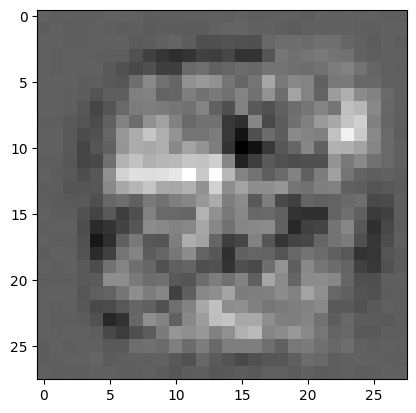

In [73]:
img = first_layer_weights[0].view(28, 28).cpu().numpy()
plt.imshow(img, cmap='gray')

* 5️⃣ Try the same thing with all the neurons of the first layer, can you see something interpretable? * Try the same thing with all the neurons of the first layer, can you see something interpretable? You can find help <a href="https://plotly.com/python/heatmaps/"> here </a> and <a href="https://plotly.com/python/subplots/"> here </a>.

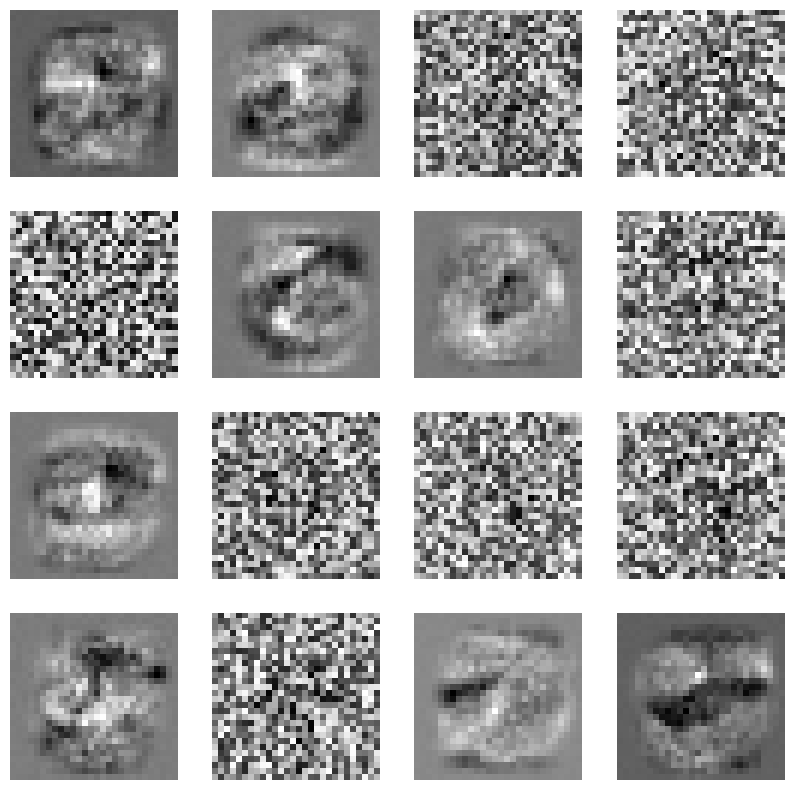

In [74]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = first_layer_weights[i].view(28, 28).cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

* 6️⃣ Do the same visualization but apply relu to the weights

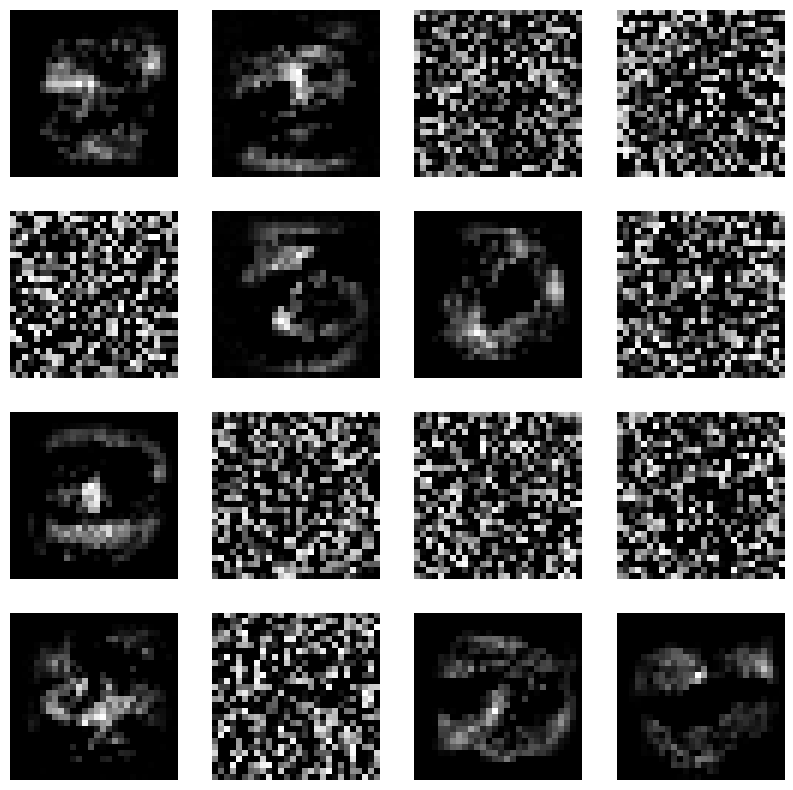

In [75]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = torch.nn.ReLU()(first_layer_weights[i]).view(28, 28).cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

## Regularization ?

* 1️⃣ What can we conclude after looking at the evolution of the losses, and looking at the feature extraction from the first layer ?

**From looking at the training loss:**
The evolution of the training loss indicates that the model is learning steadily on the training set, and shows stable consistent decrease.

**From looking at the validation loss:**
The evolution of the validation loss shows some instability, especially as the decrease in training loss slows down.

**From looking et the feature space:**
It seems as though only a portion of our neurons are actually learning something from our data (some neurons look like they are only capturing noise)

* 2️⃣ What can you do to solve this?

We can attempt some regularization techniques:
* In order to stabalize the loss we can add some L2 regularization in the optimizer.
* In order to balance out the training of our first layer we can add some drop out after that layer.

### Addind Regularization

3️⃣ Train a new neural network with some L2 regularization in the optimizer, do you notice any difference?

In [76]:
# Re-instanciate the model
model_reg = MNISTModel()
print(model)

# add L2 regularization with weight decay
optimizer = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=0.001)

# Train the model
history = train(model_reg, train_loader, val_loader, criterion, optimizer, epochs=50)


MNISTModel(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)
Epoch [1/50], Loss: 1.8026, Acc: 0.6775, Val Loss: 1.6924, Val Acc: 0.7824
Epoch [2/50], Loss: 1.6403, Acc: 0.8354, Val Loss: 1.6208, Val Acc: 0.8552
Epoch [3/50], Loss: 1.6107, Acc: 0.8617, Val Loss: 1.6093, Val Acc: 0.8617
Epoch [4/50], Loss: 1.5976, Acc: 0.8730, Val Loss: 1.5952, Val Acc: 0.8757
Epoch [5/50], Loss: 1.5895, Acc: 0.8804, Val Loss: 1.5853, Val Acc: 0.8826
Epoch [6/50], Loss: 1.5855, Acc: 0.8833, Val Loss: 1.5799, Val Acc: 0.8882
Epoch [7/50], Loss: 1.5805, Acc: 0.8876, Val Loss: 1.5929, Val Acc: 0.8737
Epoch [8/50], Loss: 1.5738, Acc: 0.8950, Val Loss: 1.5805, Val Acc: 0.8884
Epoch [9/50], Loss: 1.5711, Acc: 0.8971, Val Loss: 1.5728, Val Acc: 0.8941
Epoch [10/50], Loss: 1.5689, Acc: 0.8986, Val Loss: 1.5655, Val Acc: 0.9022
Epoch [11/5

In [77]:
fig = go.Figure(data=[
    go.Scatter(y=history["loss"], name="Training Loss", mode="lines"),
    go.Scatter(y=history["val_loss"], name="Validation Loss", mode="lines")
])
fig.update_layout(title="Training and Validation Loss", xaxis_title="Epochs", yaxis_title="Loss")
fig.show()

In [78]:
first_layer_weights = model_reg.fc1.weight.data
print(first_layer_weights.shape)  # Shape should be [16, 784]

torch.Size([16, 784])


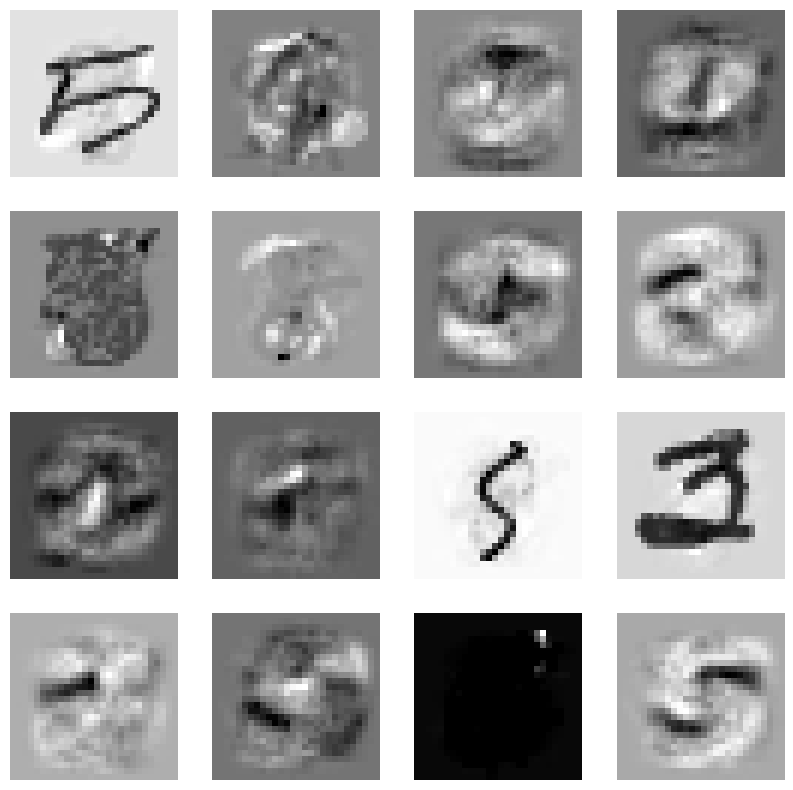

In [79]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = first_layer_weights[i].view(28, 28).cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

After adding regularization, all neurons on the first layer seem to be training, however some of them seem to focus on very specific cases.

### Adding DropOut

4️⃣ Now that we have tried regulaization, let's attempt some dropout after the first layer and see how it goes:

In [81]:
class MNISTModelDropOut(nn.Module):
    def __init__(self):
        super(MNISTModelDropOut, self).__init__()
        self.fc1 = nn.Linear(28*28, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

model_dropout = MNISTModelDropOut()
print(model_dropout)


# add L2 regularization with weight decay
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001, weight_decay=0.001)

# Train the model
history = train(model_dropout, train_loader, val_loader, criterion, optimizer, epochs=50)


MNISTModelDropOut(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.3, inplace=False)
)
Epoch [1/50], Loss: 1.9031, Acc: 0.5663, Val Loss: 1.6573, Val Acc: 0.8203
Epoch [2/50], Loss: 1.7385, Acc: 0.7344, Val Loss: 1.6203, Val Acc: 0.8564
Epoch [3/50], Loss: 1.7088, Acc: 0.7637, Val Loss: 1.5933, Val Acc: 0.8780
Epoch [4/50], Loss: 1.6940, Acc: 0.7768, Val Loss: 1.5999, Val Acc: 0.8673
Epoch [5/50], Loss: 1.6875, Acc: 0.7816, Val Loss: 1.5824, Val Acc: 0.8864
Epoch [6/50], Loss: 1.6844, Acc: 0.7847, Val Loss: 1.5921, Val Acc: 0.8780
Epoch [7/50], Loss: 1.6773, Acc: 0.7915, Val Loss: 1.5860, Val Acc: 0.8868
Epoch [8/50], Loss: 1.6699, Acc: 0.7996, Val Loss: 1.5762, Val Acc: 0.8916
Epoch [9/50], Loss: 1.6630, Acc: 0.8063, Val Loss: 1.5862, Val Acc: 0.8820
Epoch [10/50], Loss: 1.6615, Acc: 0.8

In [82]:
fig = go.Figure(data=[
    go.Scatter(y=history["loss"], name="Training Loss", mode="lines"),
    go.Scatter(y=history["val_loss"], name="Validation Loss", mode="lines")
])
fig.update_layout(title="Training and Validation Loss", xaxis_title="Epochs", yaxis_title="Loss")
fig.show()

Adding dropout increases the training loss because dropout is in effect during training and blocks part of the information flow from reaching the other neurons.

However there does not seem to be any negative effect on the validation loss.

In [83]:
first_layer_weights = model_dropout.fc1.weight.data
print(first_layer_weights.shape)  # Shape should be [16, 784]

torch.Size([16, 784])


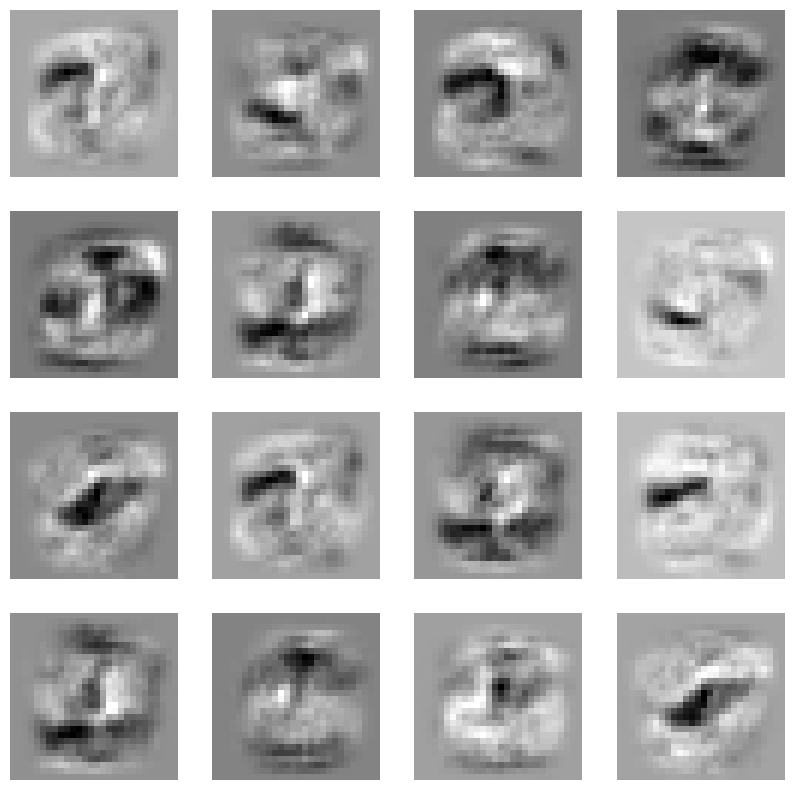

In [84]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = first_layer_weights[i].view(28, 28).cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

In terms of feature extraction in the first layer, it seems that drop out helped even things out across neurons.

## Conclusion

Analyzing the first-layer weights helps us understand what patterns the model is learning from the MNIST images. While it’s not as intuitive as human perception, it provides insights into feature extraction in neural networks.